In [1]:
import pandas as pd
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import keras as K
import tensorflow as tf
import os, json
from scipy import misc
import cv2
import pickle

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/__init__.py:1067: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
from cnn_builder import get_model

In [3]:
IMAGE_DATA_PATH = './data/simulator_data'

In [4]:
image_data = pd.read_csv(os.path.join(IMAGE_DATA_PATH, 'track_data.csv'))

In [5]:
image_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32021 entries, 0 to 32020
Data columns (total 7 columns):
center      32021 non-null object
left        32021 non-null object
right       32021 non-null object
steering    32021 non-null float64
throttle    32021 non-null float64
brake       32021 non-null float64
speed       32021 non-null float64
dtypes: float64(4), object(3)
memory usage: 1.7+ MB


In [6]:
image_data.head()

,center,left,right,steering,throttle,brake,speed
0,data/simulator_data/track/run2/IMG/center_2018...,data/simulator_data/track/run2/IMG/left_2018_0...,data/simulator_data/track/run2/IMG/right_2018_...,-0.064378,1.0,0.0,30.19027
1,data/simulator_data/track/run2/IMG/center_2018...,data/simulator_data/track/run2/IMG/left_2018_0...,data/simulator_data/track/run2/IMG/right_2018_...,-0.064378,1.0,0.0,30.19024
2,data/simulator_data/track/run2/IMG/center_2018...,data/simulator_data/track/run2/IMG/left_2018_0...,data/simulator_data/track/run2/IMG/right_2018_...,-0.064378,1.0,0.0,30.19022
3,data/simulator_data/track/run2/IMG/center_2018...,data/simulator_data/track/run2/IMG/left_2018_0...,data/simulator_data/track/run2/IMG/right_2018_...,-0.064378,1.0,0.0,30.19008
4,data/simulator_data/track/run2/IMG/center_2018...,data/simulator_data/track/run2/IMG/left_2018_0...,data/simulator_data/track/run2/IMG/right_2018_...,-0.038627,1.0,0.0,30.19044


### Train-test split 

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
ind_train, ind_test = train_test_split(np.array(range(len(image_data))), train_size=0.8, random_state = 42)

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


In [8]:
train_df = image_data.loc[ind_train]
test_df = image_data.loc[ind_test]

### Make flipping

In [9]:
flipped_img_path = os.path.join( 'data/simulator_data/track/flip_init')

In [11]:
filenames = []
values = []
for i, row in train_df.iterrows():
    imgname = row['center']
    steering = row['steering']
    imgname = imgname.strip()
    img = cv2.imread(os.path.join(imgname))
    img = cv2.flip(img, flipCode=1)
    saving_name = os.path.join(flipped_img_path, os.path.split(imgname)[-1])
    cv2.imwrite(saving_name, img)
    filenames.append(saving_name)
    values.append(-1*steering)

In [12]:
flipped_df = pd.DataFrame({'center': filenames, 'steering': values})

In [13]:
flipped_init_df = pd.concat([train_df, flipped_df], ignore_index=True)

In [14]:
flipped_init_df.tail()

,brake,center,left,right,speed,steering,throttle
51227,NaN,data/simulator_data/track/flip_init/center_201...,NaN,NaN,NaN,-0.085837,NaN
51228,NaN,data/simulator_data/track/flip_init/center_201...,NaN,NaN,NaN,0.025751,NaN
51229,NaN,data/simulator_data/track/flip_init/center_201...,NaN,NaN,NaN,0.231760,NaN
51230,NaN,data/simulator_data/track/flip_init/center_201...,NaN,NaN,NaN,0.068670,NaN
51231,NaN,data/simulator_data/track/flip_init/center_201...,NaN,NaN,NaN,-0.060086,NaN


In [15]:
flipped_init_df.head()

,brake,center,left,right,speed,steering,throttle
0,0.0,data/simulator_data/track/run3-back/IMG/center...,data/simulator_data/track/run3-back/IMG/left_2...,data/simulator_data/track/run3-back/IMG/right_...,20.94395,-0.240343,0.066289
1,0.0,data/simulator_data/track/run-5/IMG/center_201...,data/simulator_data/track/run-5/IMG/left_2018_...,data/simulator_data/track/run-5/IMG/right_2018...,21.90985,-0.326180,0.000000
2,0.0,data/simulator_data/track/run3-back/IMG/center...,data/simulator_data/track/run3-back/IMG/left_2...,data/simulator_data/track/run3-back/IMG/right_...,30.19028,0.025751,1.000000
3,0.0,data/simulator_data/track/run-6/IMG/center_201...,data/simulator_data/track/run-6/IMG/left_2018_...,data/simulator_data/track/run-6/IMG/right_2018...,27.61868,0.154506,0.000000
4,0.0,data/simulator_data/track/run3-back/IMG/center...,data/simulator_data/track/run3-back/IMG/left_2...,data/simulator_data/track/run3-back/IMG/right_...,27.81060,0.111588,0.000000


In [16]:
flipped_init_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51232 entries, 0 to 51231
Data columns (total 7 columns):
brake       25616 non-null float64
center      51232 non-null object
left        25616 non-null object
right       25616 non-null object
speed       25616 non-null float64
steering    51232 non-null float64
throttle    25616 non-null float64
dtypes: float64(4), object(3)
memory usage: 2.7+ MB


### Training the models

In [17]:
def generator_df(samples_df_, source_path='data', data_columns = ['center'], val_column = 'steering', batch_size=4):
# yields batches from dataframe samples_df: ['images', 'steering']
    samples_df = samples_df_.copy()
    num_samples = len(samples_df)
    while 1: # Loop forever so the generator never terminates
        shuffle(samples_df)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples_df[offset:offset+batch_size]

            images = None
            angles = np.array([], dtype='float32')
            for i, batch_sample in batch_samples.iterrows():
                name = batch_sample[np.random.choice(data_columns, 1)].values[0]
                name = name.strip()
                center_image = cv2.imread(os.path.join(source_path,name))
                if center_image is not None:
                    center_angle = batch_sample[val_column]
                    if images is None:
                        images = center_image[np.newaxis]
                    else:
                        images = np.vstack([images, center_image[np.newaxis]])
                    angles = np.append(angles, center_angle)

            yield images, angles

In [18]:
def predict_generator_df(samples_df_, source_path='data', data_columns = ['center'], batch_size=4):
# yields batches for predictions, no shuffling
    samples_df = samples_df_.copy()
    num_samples = len(samples_df)
    while 1: # Loop forever so the generator never terminates
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples_df[offset:offset+batch_size]

            images = None
            angles = np.array([], dtype='float32')
            for i, batch_sample in batch_samples.iterrows():
                name = batch_sample[np.random.choice(data_columns, 1)].values[0]
                name = name.strip()
                center_image = cv2.imread(os.path.join(source_path,name))
                center_angle = batch_sample['steering']
                if images is None:
                    images = center_image[np.newaxis]
                else:
                    images = np.vstack([images, center_image[np.newaxis]])
                angles = np.append(angles, center_angle)

            yield images

In [24]:
BATCH_SIZE = 8
train_generator = generator_df(flipped_init_df, source_path='', batch_size=BATCH_SIZE)
val_generator = generator_df(test_df, source_path='', batch_size=BATCH_SIZE)

#### Training VGG16-based model

In [25]:
MODEL_SAVING_PATH = 'trained_weights/my_w/vgg16_center'
from keras.callbacks import ModelCheckpoint

In [26]:
saving_path = os.path.join(MODEL_SAVING_PATH, 'weights_vgg16e_center.{epoch:02d}-{val_loss:.4f}.hdf5')
saver = ModelCheckpoint(saving_path, verbose=1, save_weights_only=True)

In [27]:
model_vgg16 = get_model('VGG16_e')
model_vgg16.compile(loss='mse', optimizer='adam')

In [29]:
history_vgg16 = model_vgg16.fit_generator(train_generator, steps_per_epoch=len(flipped_init_df)/BATCH_SIZE, validation_data=val_generator,
                                       validation_steps=len(test_df)/BATCH_SIZE, epochs=10, callbacks=[saver])

Epoch 1/10
6404/6404 [==============================] - 150s 23ms/step - loss: 0.0079 - val_loss: 0.0081

Epoch 00001: saving model to trained_weights/my_w/vgg16_center/weights_vgg16e_center.01-0.0081.hdf5
Epoch 2/10
6404/6404 [==============================] - 150s 23ms/step - loss: 0.0082 - val_loss: 0.0062

Epoch 00002: saving model to trained_weights/my_w/vgg16_center/weights_vgg16e_center.02-0.0062.hdf5
Epoch 3/10
6404/6404 [==============================] - 150s 23ms/step - loss: 0.0066 - val_loss: 0.0059

Epoch 00003: saving model to trained_weights/my_w/vgg16_center/weights_vgg16e_center.03-0.0059.hdf5
Epoch 4/10
6404/6404 [==============================] - 150s 23ms/step - loss: 0.0058 - val_loss: 0.0057

Epoch 00004: saving model to trained_weights/my_w/vgg16_center/weights_vgg16e_center.04-0.0057.hdf5
Epoch 5/10
6404/6404 [==============================] - 150s 23ms/step - loss: 0.0054 - val_loss: 0.0053

Epoch 00005: saving model to trained_weights/my_w/vgg16_center/weights

#### Training NVIDIA-style model

In [34]:
saving_path = os.path.join(MODEL_SAVING_PATH, 'nvidia_my', 'weights_nvidia_my.{epoch:02d}-{val_loss:.4f}.hdf5')
saver = ModelCheckpoint(saving_path, verbose=1, save_weights_only=True)

In [35]:
model_nvidia = get_model('NVIDIA')
model_nvidia.compile(loss='mse', optimizer='adam')

In [36]:
history_nvidia = model_nvidia.fit_generator(train_generator, steps_per_epoch=len(train_df)/BATCH_SIZE, validation_data=val_generator,
                                       validation_steps=len(test_df)/BATCH_SIZE, epochs=10, callbacks=[saver])

Epoch 1/10
804/803 [==============================] - 14s 18ms/step - loss: 0.6236 - val_loss: 0.0154

Epoch 00001: saving model to trained_weights/nvidia/weights_nvidia.01-0.0154.hdf5
Epoch 2/10
804/803 [==============================] - 14s 17ms/step - loss: 0.0098 - val_loss: 0.0135

Epoch 00002: saving model to trained_weights/nvidia/weights_nvidia.02-0.0135.hdf5
Epoch 3/10
804/803 [==============================] - 14s 17ms/step - loss: 0.0052 - val_loss: 0.0154

Epoch 00003: saving model to trained_weights/nvidia/weights_nvidia.03-0.0154.hdf5
Epoch 4/10
804/803 [==============================] - 14s 17ms/step - loss: 0.0032 - val_loss: 0.0142

Epoch 00004: saving model to trained_weights/nvidia/weights_nvidia.04-0.0142.hdf5
Epoch 5/10
804/803 [==============================] - 14s 17ms/step - loss: 0.0036 - val_loss: 0.0142

Epoch 00005: saving model to trained_weights/nvidia/weights_nvidia.05-0.0142.hdf5
Epoch 6/10
804/803 [==============================] - 14s 17ms/step - loss:

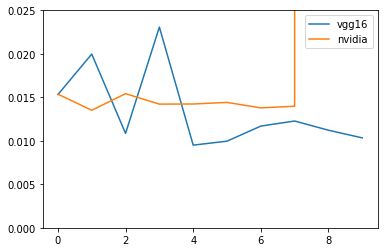

In [45]:
plt.plot(history_vgg16.history['val_loss'])
plt.plot(history_nvidia.history['val_loss'])
plt.ylim((0,0.025))
plt.legend(['vgg16', 'nvidia'])
plt.show()

### Load pretrained model (for experiments)

In [16]:
from keras.models import load_model

In [22]:
model_vgg16.load_weights('trained_weights/vgg16_my/weights_vgg16.08-0.0037.hdf5')

### Try to use left and right images

In [23]:
center_generator = predict_generator_df(train_df, source_path='', data_columns = ['center'], batch_size=BATCH_SIZE)
left_generator = predict_generator_df(train_df, source_path='', data_columns=['left'], batch_size=BATCH_SIZE)
right_generator = predict_generator_df(train_df, source_path='', data_columns=['right'], batch_size=BATCH_SIZE)

In [24]:
center_predictions = model_vgg16.predict_generator(center_generator, steps=len(train_df)/BATCH_SIZE)

In [25]:
center_predictions = center_predictions.flatten()

In [26]:
left_predictions = model_vgg16.predict_generator(left_generator, steps=len(train_df)/BATCH_SIZE).flatten()

In [27]:
right_predictions = model_vgg16.predict_generator(right_generator, steps=len(train_df)/BATCH_SIZE).flatten()

#### Here we calculate correction factors between predictions

In [28]:
left_delta = np.mean(center_predictions - left_predictions)
right_delta = np.mean(center_predictions - right_predictions)

In [29]:
print(left_delta, right_delta)

-0.020963809 0.023573231


#### Make extended dataset with all images used

In [30]:
left_steering = train_df['steering'].values - left_delta
right_steering = train_df['steering'].values - right_delta

In [31]:
train_df_ext = train_df
train_df_ext['left_steering'] = train_df['steering'] - left_delta
train_df_ext['right_steering'] = train_df['steering'] - right_delta
train_df_ext.head()

,center,left,right,steering,throttle,brake,speed,left_steering,right_steering
29269,data/simulator_data/track/run3-back/IMG/center...,data/simulator_data/track/run3-back/IMG/left_2...,data/simulator_data/track/run3-back/IMG/right_...,-0.240343,0.066289,0.0,20.94395,-0.219379,-0.263917
4416,data/simulator_data/track/run-5/IMG/center_201...,data/simulator_data/track/run-5/IMG/left_2018_...,data/simulator_data/track/run-5/IMG/right_2018...,-0.326180,0.000000,0.0,21.90985,-0.305216,-0.349754
29698,data/simulator_data/track/run3-back/IMG/center...,data/simulator_data/track/run3-back/IMG/left_2...,data/simulator_data/track/run3-back/IMG/right_...,0.025751,1.000000,0.0,30.19028,0.046715,0.002178
25176,data/simulator_data/track/run-6/IMG/center_201...,data/simulator_data/track/run-6/IMG/left_2018_...,data/simulator_data/track/run-6/IMG/right_2018...,0.154506,0.000000,0.0,27.61868,0.175470,0.130933
27055,data/simulator_data/track/run3-back/IMG/center...,data/simulator_data/track/run3-back/IMG/left_2...,data/simulator_data/track/run3-back/IMG/right_...,0.111588,0.000000,0.0,27.81060,0.132552,0.088015


In [35]:
train_df_ext.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25616 entries, 29269 to 23654
Data columns (total 9 columns):
center            25616 non-null object
left              25616 non-null object
right             25616 non-null object
steering          25616 non-null float64
throttle          25616 non-null float64
brake             25616 non-null float64
speed             25616 non-null float64
left_steering     25616 non-null float64
right_steering    25616 non-null float64
dtypes: float64(6), object(3)
memory usage: 2.0+ MB


In [32]:
train_df_joint = train_df_ext[['center', 'steering']].rename(columns={'center': 'image', 'steering': 'value'})
train_df_joint = pd.concat([train_df_joint,
                           train_df_ext[['left', 'left_steering']].rename(columns={'left': 'image', 'left_steering': 'value'})],
                          ignore_index=True)
train_df_joint = pd.concat([train_df_joint,
                           train_df_ext[['right', 'right_steering']].rename(columns={'right': 'image', 'right_steering': 'value'})],
                          ignore_index=True)
train_df_joint.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76848 entries, 0 to 76847
Data columns (total 2 columns):
image    76848 non-null object
value    76848 non-null float64
dtypes: float64(1), object(1)
memory usage: 1.2+ MB


In [34]:
train_df_joint.head()

,image,value
0,data/simulator_data/track/run3-back/IMG/center...,-0.240343
1,data/simulator_data/track/run-5/IMG/center_201...,-0.326180
2,data/simulator_data/track/run3-back/IMG/center...,0.025751
3,data/simulator_data/track/run-6/IMG/center_201...,0.154506
4,data/simulator_data/track/run3-back/IMG/center...,0.111588


## Make flipping

In [51]:
flipped_img_path = os.path.join( 'data/simulator_data/track/flipped')

In [52]:
filenames = []
values = []
for i, row in train_df_joint.iterrows():
    imgname = row['image']
    steering = row['value']
    imgname = imgname.strip()
    img = cv2.imread(os.path.join(imgname))
    img = cv2.flip(img, flipCode=1)
    saving_name = os.path.join(flipped_img_path, os.path.split(imgname)[-1])
    cv2.imwrite(saving_name, img)
    filenames.append(saving_name)
    values.append(-1*steering)

In [38]:
flipped_df = pd.DataFrame({'image': filenames, 'value': values})

In [39]:
flipped_df = pd.concat([train_df_joint, flipped_df], ignore_index=True)
flipped_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153696 entries, 0 to 153695
Data columns (total 2 columns):
image    153696 non-null object
value    153696 non-null float64
dtypes: float64(1), object(1)
memory usage: 2.3+ MB


In [53]:
flipped_df.tail()

,image,value
153691,data/simulator_data/track/flipped/right_2018_0...,-0.062264
153692,data/simulator_data/track/flipped/right_2018_0...,0.049324
153693,data/simulator_data/track/flipped/right_2018_0...,0.255333
153694,data/simulator_data/track/flipped/right_2018_0...,0.092243
153695,data/simulator_data/track/flipped/right_2018_0...,-0.036513


### Training models on joint and flipped dataset

In [54]:
train_generator_flipped = generator_df(flipped_df, source_path='', data_columns=['image'], val_column='value', batch_size=BATCH_SIZE)

In [99]:
model_vgg16e_flipped = get_model('VGG16_e')
model_vgg16e_flipped.compile(optimizer='adam', loss='mse')

In [60]:
model_nvidia_flipped = get_model('NVIDIA')
model_nvidia_flipped.compile(optimizer='adam', loss='mse')

In [96]:
saving_path = os.path.join(MODEL_SAVING_PATH, 'vgg16_flipped_my', 'weights_vgg16_flipped_my.{epoch:02d}-{val_loss:.4f}.hdf5')
saver_vgg = ModelCheckpoint(saving_path, verbose=1, save_weights_only=True)

In [61]:
saving_path = os.path.join(MODEL_SAVING_PATH, 'nvidia_flipped', 'weights_nvidia_flipped.{epoch:02d}-{val_loss:.4f}.hdf5')
saver_nvidia = ModelCheckpoint(saving_path, verbose=1, save_weights_only=True)

In [58]:
history_vgg16e_flipped = model_vgg16e.fit_generator(train_generator_flipped, steps_per_epoch=len(flipped_df)/BATCH_SIZE,
                                     validation_data = val_generator, validation_steps=len(test_df)/BATCH_SIZE,
                                 callbacks=[saver_vgg], epochs=10)

Epoch 1/10
19212/19212 [==============================] - 378s 20ms/step - loss: 0.0415 - val_loss: 0.0194

Epoch 00001: saving model to trained_weights/vgg16e_flipped_my/weights_vgg16e_flipped_my.01-0.0194.hdf5
Epoch 2/10
19212/19212 [==============================] - 378s 20ms/step - loss: 0.0080 - val_loss: 0.0090

Epoch 00002: saving model to trained_weights/vgg16e_flipped_my/weights_vgg16e_flipped_my.02-0.0090.hdf5
Epoch 3/10
19212/19212 [==============================] - 378s 20ms/step - loss: 0.0058 - val_loss: 0.0070

Epoch 00003: saving model to trained_weights/vgg16e_flipped_my/weights_vgg16e_flipped_my.03-0.0070.hdf5
Epoch 4/10
19212/19212 [==============================] - 378s 20ms/step - loss: 0.0054 - val_loss: 0.0069

Epoch 00004: saving model to trained_weights/vgg16e_flipped_my/weights_vgg16e_flipped_my.04-0.0069.hdf5
Epoch 5/10
19212/19212 [==============================] - 378s 20ms/step - loss: 0.0052 - val_loss: 0.0065

Epoch 00005: saving model to trained_weights

In [62]:
history_nvidia_flipped = model_nvidia_flipped.fit_generator(train_generator_flipped, steps_per_epoch=len(flipped_df)/BATCH_SIZE,
                                     validation_data = val_generator, validation_steps=len(test_df)/BATCH_SIZE,
                                 callbacks=[saver_nvidia], epochs=10)

Epoch 1/10
19212/19212 [==============================] - 319s 17ms/step - loss: 511.8605 - val_loss: 0.2383

Epoch 00001: saving model to trained_weights/nvidia_flipped/weights_nvidia_flipped.01-0.2383.hdf5
Epoch 2/10
19212/19212 [==============================] - 319s 17ms/step - loss: 421.7276 - val_loss: 0.2795

Epoch 00002: saving model to trained_weights/nvidia_flipped/weights_nvidia_flipped.02-0.2795.hdf5
Epoch 3/10
19212/19212 [==============================] - 319s 17ms/step - loss: 498.9718 - val_loss: 0.0843

Epoch 00003: saving model to trained_weights/nvidia_flipped/weights_nvidia_flipped.03-0.0843.hdf5
Epoch 4/10
19212/19212 [==============================] - 319s 17ms/step - loss: 449.6086 - val_loss: 0.0765

Epoch 00004: saving model to trained_weights/nvidia_flipped/weights_nvidia_flipped.04-0.0765.hdf5
Epoch 5/10
19212/19212 [==============================] - 319s 17ms/step - loss: 8468.1190 - val_loss: 0.0953

Epoch 00005: saving model to trained_weights/nvidia_flipp

In [112]:
with open(os.path.join('train_history', 'history_vgg16.json'), 'w') as f:
    json.dump(history_vgg16.history, f)

In [114]:
with open(os.path.join('train_history', 'history_nvidia.json'), 'w') as f:
    json.dump(history_nvidia.history, f)

In [115]:
with open(os.path.join('train_history', 'history_vgg16_joint.json'), 'w') as f:
    json.dump(history_vgg16_joint.history, f)

In [116]:
with open(os.path.join('train_history', 'history_vgg16_flipped.json'), 'w') as f:
    json.dump(history_vgg16_flipped.history, f)

In [117]:
with open(os.path.join('train_history', 'history_vgg16e_flipped.json'), 'w') as f:
    json.dump(history_vgg16e_flipped.history, f)

In [118]:
with open(os.path.join('train_history', 'history_nvidia_joint.json'), 'w') as f:
    json.dump(history_nvidia_joint.history, f)

In [119]:
with open(os.path.join('train_history', 'history_nvidia_flipped.json'), 'w') as f:
    json.dump(history_nvidia_flipped.history, f)

In [125]:
with open(os.path.join('datasets', 'train_df.p'), 'wb') as f:
    pickle.dump(train_df, f)

In [126]:
with open(os.path.join('datasets', 'train_df_joint.p'), 'wb') as f:
    pickle.dump(train_df_joint, f)

In [128]:
with open(os.path.join('datasets', 'train_df_flipped.p'), 'wb') as f:
    pickle.dump(flipped_df, f)

In [129]:
with open(os.path.join('datasets', 'test_df.p'), 'wb') as f:
    pickle.dump(test_df, f)